## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [8]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]


Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

Epoch 48/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0958 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 174us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 168us/step - loss: 2.4626 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Den

50000/50000 [==============================] - 8s 160us/step - loss: 0.8518 - acc: 0.7026 - val_loss: 1.3910 - val_acc: 0.5336
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__________________________________

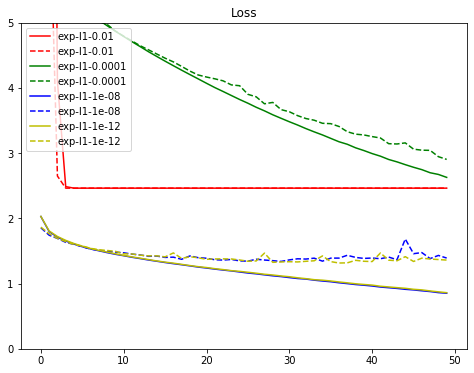

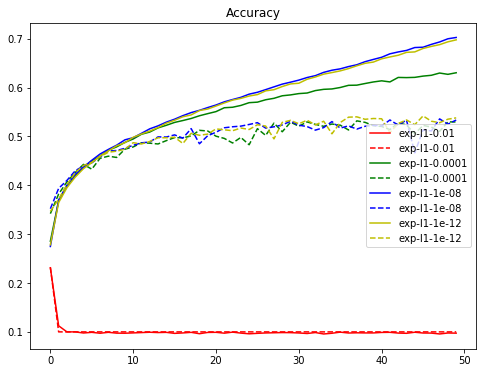

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同L1的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.1707 - acc: 0.2737 - val_loss: 2.0093 - val_acc: 0.3473
Epoch 2/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.9462 - acc: 0.3668 - val_loss: 1.8976 - val_acc: 0.3767
Epoch 3/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.8601 - acc: 0.3970 - val_loss: 1.8309 - val_acc: 0.4053
Epoch 4/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.8007 - acc: 0.4169 - val_loss: 1.7769 - val_acc: 0.4259
Epoch 5/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.7530 - acc: 0.4348 - val_loss: 1.7396 - val_acc: 0.4417
Epoch 6/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.7145 - acc: 0.4471 - val_loss: 1.7052 - val_acc: 0.4502
Epoch 7/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.6792 - acc: 0.4600 - val_loss: 1.6848 - val_ac

50000/50000 [==============================] - 4s 90us/step - loss: 1.8080 - acc: 0.3691 - val_loss: 1.7594 - val_acc: 0.3864
Epoch 3/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.7227 - acc: 0.3997 - val_loss: 1.6925 - val_acc: 0.4061
Epoch 4/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.6612 - acc: 0.4216 - val_loss: 1.6394 - val_acc: 0.4284
Epoch 5/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.6122 - acc: 0.4366 - val_loss: 1.5961 - val_acc: 0.4389
Epoch 6/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.5714 - acc: 0.4517 - val_loss: 1.5722 - val_acc: 0.4524
Epoch 7/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.5391 - acc: 0.4618 - val_loss: 1.5337 - val_acc: 0.4648
Epoch 8/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.5080 - acc: 0.4727 - val_loss: 1.5236 - val_acc: 0.4586
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 90us/step - loss: 1.7193 - acc: 0.3946 - val_loss: 1.6855 - val_acc: 0.4125
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6620 - acc: 0.4168 - val_loss: 1.6507 - val_acc: 0.4237
Epoch 5/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.6164 - acc: 0.4341 - val_loss: 1.6200 - val_acc: 0.4320
Epoch 6/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.5760 - acc: 0.4464 - val_loss: 1.5723 - val_acc: 0.4504
Epoch 7/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.5416 - acc: 0.4607 - val_loss: 1.5483 - val_acc: 0.4576
Epoch 8/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.5117 - acc: 0.4698 - val_loss: 1.5231 - val_acc: 0.4578
Epoch 9/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.4847 - acc: 0.4784 - val_loss: 1.5160 - val_acc: 0.4625
Epoch 10/50
50000/50000 [===========================

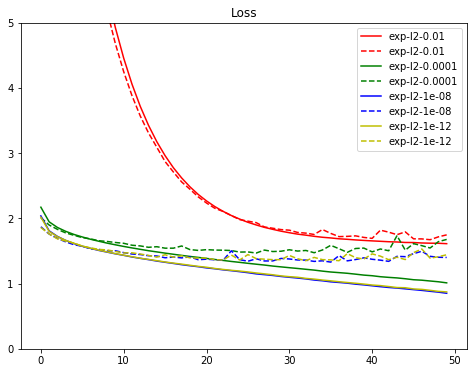

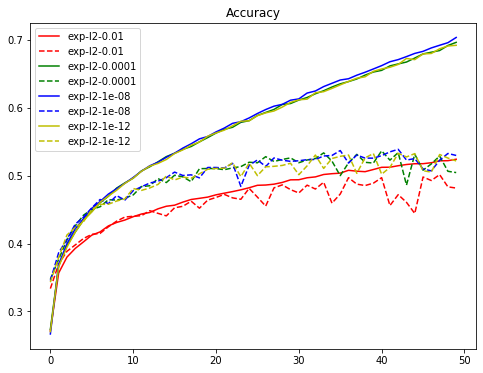

In [9]:
results = {}
"""
使用迴圈建立不同的帶不同L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()